In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import os
from os import listdir
from os.path import isfile, join

import collections
from tqdm import tqdm, tqdm_notebook
from PIL import Image

from sklearn.model_selection import train_test_split
import string
import torchmetrics

# Подготовка данных

In [5]:
# !unzip laba-dataset.zip

In [6]:
data_dir = "./samples/"
data = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
len(data)

1070

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [8]:
all_symbols = string.ascii_lowercase + string.digits

symbol_to_class = {}
class_to_symbol = {}
for idx, symbol in enumerate(all_symbols):
    symbol_to_class[symbol] = idx + 1
    class_to_symbol[idx + 1] = symbol

symbol_to_class["-"] = 0
class_to_symbol[0] = "-"
num_class = len(symbol_to_class)
print(num_class)

37


In [9]:
num_classes = len(class_to_symbol.keys())
num_classes

37

In [10]:
images = []
labels = []
for name in data:
    images.append(os.path.join(data_dir, name))
    lab = name.split(".")[-2]
    lab = [symbol_to_class[symb] for symb in lab]
    labels.append(lab)
    
df_data = {"images_paths": images, "labels": labels}
df = pd.DataFrame(df_data)
df.head()

,images_paths,labels
0,./samples/226md.png,"[29, 29, 33, 13, 4]"
1,./samples/22d5n.png,"[29, 29, 4, 32, 14]"
2,./samples/2356g.png,"[29, 30, 32, 33, 7]"
3,./samples/23mdg.png,"[29, 30, 13, 4, 7]"
4,./samples/23n88.png,"[29, 30, 14, 35, 35]"


In [11]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [12]:
class CustomDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.paths = df["images_paths"].to_list()
        self.labels = df["labels"].to_list()
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("L")
        label = torch.tensor(self.labels[idx], dtype=torch.int32)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
        
     
transform_train = T.Compose([
    T.ToTensor(),
    T.Resize((50, 200)),
    # T.RandomRotation(degrees=20)
    # T.ColorJitter() # brightness=0, contrast=0, saturation=0, hue=0
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Resize((50, 200))
])

train_data = CustomDataset(df_train, transform_train)
test_data = CustomDataset(df_test, transform_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

# Создание и обучение модели. Подсчет метрик.

In [57]:
class CaptchaRecognitionModel(nn.Module):

    def __init__(self, in_channels, num_classes=num_classes):
        super(CaptchaRecognitionModel, self).__init__()
        # channels = [in_channels, 64, 128, 256, 512, 512]
        
        # layers = []
        # for idx in range(1, len(channels)):
        #     if idx <= 3:
        #         pool_kernel_size = 2
        #     elif 3 < idx <= 4:
        #         pool_kernel_size = (1, 1)
        #     else:
        #         pool_kernel_size = (1, 2)
                
        #     layer = nn.Sequential(
        #         nn.Conv2d(in_channels=channels[idx-1], out_channels=channels[idx], kernel_size=3, stride=1, padding=1),
        #         nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2),
        #         nn.BatchNorm2d(channels[idx]),
        #         nn.ReLU(),
        #     )
        #     layers.append(layer)
        # self.cnn = nn.Sequential(*layers)
        self.cnn = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
              nn.MaxPool2d(kernel_size=(1, 2), stride=2),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(512),
              nn.ReLU(),

              nn.MaxPool2d(kernel_size=(1, 2), stride=2),
              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=1, padding=0),
              nn.BatchNorm2d(512),
              nn.ReLU(),
        )
        self.lin1 = nn.Linear(512 * 2, 128)   
        self.lstm = nn.LSTM(128, 256, num_layers=2, bidirectional=True)
        self.embed = nn.Linear(2 * 256, num_classes)
        
    def forward(self, x):

        out = self.cnn(x)
        N, C, w, h = out.size()
        out = out.view(N, -1, h)
        out = out.permute(0, 2, 1)
        out = self.lin1(out)
        out = out.permute(1, 0, 2)
        out, _ = self.lstm(out)
        out = self.embed(out)
    
        input_lengths = torch.full(size=(out.size(1),), fill_value=out.size(0), dtype=torch.int32)
        target_lengths = torch.full(size=(out.size(1),), fill_value=5, dtype=torch.int32)
        return out, input_lengths, target_lengths
        

In [78]:
def train(
    model, optimizer, criterion, epochs=50, device=device, 
    train_loader=None, test_loader=None, scheduler=None, metric=None
    ):
        
    def fit():
        hist_loss = []
        test_cer_epochs = []
        for epoch in tqdm(range(epochs)):
            model.train()
            running_cer = 0
            running_loss = 0
            for batch_images, gt_labels in train_loader:
                batch_images = batch_images.to(device)
                gt_labels = gt_labels.to(device)
                optimizer.zero_grad()
                
                out, input_lengths, target_lengths = model(batch_images)
                log_prob = F.log_softmax(out, dim=2)
                
                loss = criterion(log_prob, gt_labels, input_lengths, target_lengths)
                running_loss += loss.item()
                loss.backward()
                optimizer.step()
                out = out.permute(1, 0, 2)
                out = out.log_softmax(2)
                out = out.argmax(-1)
                decoded_out = decode_ctc(out, class_to_symbol)
                decoded_gt_labels = decode_ctc(gt_labels, class_to_symbol)
                
                cer = metric(decoded_out, decoded_gt_labels)
                running_cer += cer
                
    
            epoch_loss = running_loss / len(train_loader)
            epoch_cer = running_cer / len(train_loader)
            print(f"Epoch {epoch}| Train Loss: {epoch_loss}| Train CER {epoch_cer}")

            decoded_outs, decoded_labs_all, test_loss = test()

        return decoded_outs, decoded_labs_all, test_loss
    def test():
        model.eval()
        batch_cer = 0
        batch_loss = 0
        decoded_outs = []
        decoded_labs_all = []
        with torch.no_grad():
            for batch_images, gt_labels in test_loader:
                batch_images = batch_images.to(device)
                gt_labels = gt_labels.to(device)
                out, input_lengths, target_lengths = model(batch_images)
                log_prob = F.log_softmax(out, dim=2)
                loss = criterion(log_prob, gt_labels, input_lengths, target_lengths)
                batch_loss += loss.item()
                out = out.permute(1, 0, 2)
                out = out.log_softmax(2)
                out = out.argmax(-1)
                decoded_out = decode_ctc(out, class_to_symbol)
                decoded_gt_labels = decode_ctc(gt_labels, class_to_symbol)
                decoded_outs.append(decoded_out)
                decoded_labs_all.append(decoded_gt_labels)
                cer = metric(decoded_out, decoded_gt_labels)
                batch_cer += cer
                
            test_loss = batch_loss / len(test_loader)
            test_cer = batch_cer / len(test_loader)
            # scheduler.step(test_cer[-1])
            scheduler.step(test_loss)
            print(f"Test Loss:, {test_loss} | Test CER {test_cer}")
        return decoded_outs, decoded_labs_all, test_loss
    decoded_outs, decoded_labs_all, test_loss = fit()
    return model, decoded_outs, decoded_labs_all, test_loss

In [79]:
def decode_ctc(preds, class_to_symbol):
    batch_res = []
    for elem in preds:
        res = ""
        for ch in elem:
            if ch.item() == 0:
                continue
            else:
                res += class_to_symbol[ch.item()]
        batch_res.append(res)
    return batch_res
        

In [80]:
model = CaptchaRecognitionModel(in_channels=1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
epoch_num = 75
criterion = nn.CTCLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, factor=0.3, patience=10, verbose=True, threshold=0.01
)
metric = torchmetrics.CharErrorRate()
model, decoded_outs, decoded_labs_all, test_loss = train(model, optim, criterion, epoch_num, device, train_loader, test_loader, scheduler, metric)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 0| Train Loss: 3.962541171482631| Train CER 1.0812499523162842


  1%|▏         | 1/75 [00:01<02:20,  1.90s/it]

Test Loss:, 3.2650161385536194 | Test CER 1.0
Epoch 1| Train Loss: 3.2551519700459073| Train CER 1.0


  3%|▎         | 2/75 [00:03<02:26,  2.01s/it]

Test Loss:, 3.2294276356697083 | Test CER 1.0
Epoch 2| Train Loss: 3.230800747871399| Train CER 1.0


  4%|▍         | 3/75 [00:06<02:27,  2.05s/it]

Test Loss:, 3.2186055183410645 | Test CER 1.0
Epoch 3| Train Loss: 3.2285306794302806| Train CER 1.0


  5%|▌         | 4/75 [00:08<02:26,  2.07s/it]

Test Loss:, 3.232356309890747 | Test CER 1.0
Epoch 4| Train Loss: 3.2237983431134904| Train CER 1.0


  7%|▋         | 5/75 [00:10<02:27,  2.11s/it]

Test Loss:, 3.2208282351493835 | Test CER 1.0
Epoch 5| Train Loss: 3.224017381668091| Train CER 1.0


  8%|▊         | 6/75 [00:12<02:22,  2.07s/it]

Test Loss:, 3.2164820432662964 | Test CER 1.0
Epoch 6| Train Loss: 3.174220766339983| Train CER 1.0


  9%|▉         | 7/75 [00:14<02:17,  2.03s/it]

Test Loss:, 3.155783474445343 | Test CER 1.0
Epoch 7| Train Loss: 3.0490710394723073| Train CER 1.0


 11%|█         | 8/75 [00:16<02:17,  2.05s/it]

Test Loss:, 2.9601246118545532 | Test CER 1.0
Epoch 8| Train Loss: 2.8963852439607893| Train CER 1.0


 12%|█▏        | 9/75 [00:18<02:16,  2.06s/it]

Test Loss:, 3.0773152709007263 | Test CER 1.0
Epoch 9| Train Loss: 2.768446445465088| Train CER 0.9918155074119568


 13%|█▎        | 10/75 [00:20<02:14,  2.07s/it]

Test Loss:, 2.6711220145225525 | Test CER 0.9612215757369995
Epoch 10| Train Loss: 2.53822546345847| Train CER 0.9382439851760864


 15%|█▍        | 11/75 [00:22<02:11,  2.06s/it]

Test Loss:, 2.4295830726623535 | Test CER 0.9039062261581421
Epoch 11| Train Loss: 2.2431338855198453| Train CER 0.8671131134033203


 16%|█▌        | 12/75 [00:24<02:09,  2.06s/it]

Test Loss:, 2.1405858397483826 | Test CER 0.8354403972625732
Epoch 12| Train Loss: 1.9346171958105904| Train CER 0.7761161923408508


 17%|█▋        | 13/75 [00:26<02:07,  2.05s/it]

Test Loss:, 1.8250917792320251 | Test CER 0.7449573874473572
Epoch 13| Train Loss: 1.607869667666299| Train CER 0.6258183717727661


 19%|█▊        | 14/75 [00:28<02:04,  2.04s/it]

Test Loss:, 1.5295950770378113 | Test CER 0.5732954740524292
Epoch 14| Train Loss: 1.2885409934180123| Train CER 0.5061756372451782


 20%|██        | 15/75 [00:30<02:03,  2.06s/it]

Test Loss:, 1.3305000960826874 | Test CER 0.5446022748947144
Epoch 15| Train Loss: 1.0601921677589417| Train CER 0.4018600881099701


 21%|██▏       | 16/75 [00:32<02:01,  2.05s/it]

Test Loss:, 1.143719643354416 | Test CER 0.43884944915771484
Epoch 16| Train Loss: 0.8455347035612378| Train CER 0.29627975821495056


 23%|██▎       | 17/75 [00:34<01:59,  2.05s/it]

Test Loss:, 0.9052511155605316 | Test CER 0.34332385659217834
Epoch 17| Train Loss: 0.6310073563030788| Train CER 0.20818449556827545


 24%|██▍       | 18/75 [00:37<01:57,  2.07s/it]

Test Loss:, 0.6873370260000229 | Test CER 0.19453126192092896
Epoch 18| Train Loss: 0.47826930454799105| Train CER 0.14866070449352264


 25%|██▌       | 19/75 [00:39<01:56,  2.08s/it]

Test Loss:, 0.6536752134561539 | Test CER 0.21825283765792847
Epoch 19| Train Loss: 0.3673893213272095| Train CER 0.1138392761349678


 27%|██▋       | 20/75 [00:41<01:54,  2.08s/it]

Test Loss:, 0.6201350465416908 | Test CER 0.208877831697464
Epoch 20| Train Loss: 0.26632153349263327| Train CER 0.08660714328289032


 28%|██▊       | 21/75 [00:43<01:52,  2.08s/it]

Test Loss:, 0.6730076298117638 | Test CER 0.23913352191448212
Epoch 21| Train Loss: 0.2133120202592441| Train CER 0.07485119253396988


 29%|██▉       | 22/75 [00:45<01:47,  2.03s/it]

Test Loss:, 0.41636093333363533 | Test CER 0.14098010957241058
Epoch 22| Train Loss: 0.12855414194720133| Train CER 0.04159226268529892


 31%|███       | 23/75 [00:47<01:46,  2.05s/it]

Test Loss:, 0.32945265620946884 | Test CER 0.12123578786849976
Epoch 23| Train Loss: 0.09265545862061637| Train CER 0.03229166939854622


 32%|███▏      | 24/75 [00:49<01:44,  2.04s/it]

Test Loss:, 0.3151296637952328 | Test CER 0.10113636404275894
Epoch 24| Train Loss: 0.07591535390487739| Train CER 0.02544642984867096


 33%|███▎      | 25/75 [00:51<01:41,  2.02s/it]

Test Loss:, 0.40490514039993286 | Test CER 0.13515625894069672
Epoch 25| Train Loss: 0.08676749787160329| Train CER 0.0331101194024086


 35%|███▍      | 26/75 [00:53<01:38,  2.02s/it]

Test Loss:, 0.3419182226061821 | Test CER 0.11882102489471436
Epoch 26| Train Loss: 0.08206827406372343| Train CER 0.02968749962747097


 36%|███▌      | 27/75 [00:55<01:37,  2.03s/it]

Test Loss:, 0.4899025857448578 | Test CER 0.14794033765792847
Epoch 27| Train Loss: 0.060730667784810066| Train CER 0.02663690410554409


 37%|███▋      | 28/75 [00:57<01:35,  2.03s/it]

Test Loss:, 0.30712712556123734 | Test CER 0.09417614340782166
Epoch 28| Train Loss: 0.037237339919166904| Train CER 0.0182291679084301


 39%|███▊      | 29/75 [00:59<01:35,  2.08s/it]

Test Loss:, 0.267343457788229 | Test CER 0.09488636255264282
Epoch 29| Train Loss: 0.029068168784890856| Train CER 0.015550595708191395


 40%|████      | 30/75 [01:01<01:33,  2.08s/it]

Test Loss:, 0.29386597871780396 | Test CER 0.09183238446712494
Epoch 30| Train Loss: 0.0246166208359812| Train CER 0.015327381901443005


 41%|████▏     | 31/75 [01:03<01:30,  2.06s/it]

Test Loss:, 0.2168684732168913 | Test CER 0.0778409093618393
Epoch 31| Train Loss: 0.040432618531797616| Train CER 0.02373511902987957


 43%|████▎     | 32/75 [01:05<01:27,  2.04s/it]

Test Loss:, 0.2819130942225456 | Test CER 0.10823863744735718
Epoch 32| Train Loss: 0.04264740299965654| Train CER 0.02470238134264946


 44%|████▍     | 33/75 [01:07<01:26,  2.05s/it]

Test Loss:, 0.22550653666257858 | Test CER 0.06853692978620529
Epoch 33| Train Loss: 0.03792252078918474| Train CER 0.02313988097012043


 45%|████▌     | 34/75 [01:09<01:23,  2.04s/it]

Test Loss:, 0.21141192689538002 | Test CER 0.08068181574344635
Epoch 34| Train Loss: 0.026013822427817752| Train CER 0.02366071566939354


 47%|████▋     | 35/75 [01:11<01:22,  2.06s/it]

Test Loss:, 0.19522243738174438 | Test CER 0.07088068872690201
Epoch 35| Train Loss: 0.017373511966850077| Train CER 0.01607142947614193


 48%|████▊     | 36/75 [01:13<01:20,  2.07s/it]

Test Loss:, 0.16173228714615107 | Test CER 0.05930398032069206
Epoch 36| Train Loss: 0.012085178334798132| Train CER 0.01696428656578064


 49%|████▉     | 37/75 [01:16<01:18,  2.05s/it]

Test Loss:, 0.1889979373663664 | Test CER 0.0661221593618393
Epoch 37| Train Loss: 0.007359514245763421| Train CER 0.012053572572767735


 51%|█████     | 38/75 [01:17<01:15,  2.03s/it]

Test Loss:, 0.15941121149808168 | Test CER 0.048366475850343704
Epoch 38| Train Loss: 0.005185975560120174| Train CER 0.01183035783469677


 52%|█████▏    | 39/75 [01:20<01:14,  2.06s/it]

Test Loss:, 0.14692888967692852 | Test CER 0.04992898181080818
Epoch 39| Train Loss: 0.004316255799494684| Train CER 0.01108630932867527


 53%|█████▎    | 40/75 [01:22<01:11,  2.04s/it]

Test Loss:, 0.14488764572888613 | Test CER 0.046875
Epoch 40| Train Loss: 0.003818109249030905| Train CER 0.01049107126891613


 55%|█████▍    | 41/75 [01:24<01:09,  2.05s/it]

Test Loss:, 0.1475068088620901 | Test CER 0.04765624925494194
Epoch 41| Train Loss: 0.0035155145617734107| Train CER 0.009598215110599995


 56%|█████▌    | 42/75 [01:26<01:08,  2.07s/it]

Test Loss:, 0.14602429093793035 | Test CER 0.04843749850988388
Epoch 42| Train Loss: 0.0032697205065882634| Train CER 0.01116071455180645


 57%|█████▋    | 43/75 [01:28<01:06,  2.08s/it]

Test Loss:, 0.14583707484416664 | Test CER 0.04843749850988388
Epoch 43| Train Loss: 0.0030348309415525626| Train CER 0.009598213247954845


 59%|█████▊    | 44/75 [01:30<01:04,  2.08s/it]

Test Loss:, 0.14726600609719753 | Test CER 0.04765624925494194
Epoch 44| Train Loss: 0.002865292248316109| Train CER 0.01034226268529892


 60%|██████    | 45/75 [01:32<01:02,  2.09s/it]

Test Loss:, 0.14840354165062308 | Test CER 0.04765624925494194
Epoch 45| Train Loss: 0.00272467196919024| Train CER 0.010119047947227955


 61%|██████▏   | 46/75 [01:34<01:00,  2.09s/it]

Test Loss:, 0.14599039824679494 | Test CER 0.04999999701976776
Epoch 46| Train Loss: 0.0025561183325148056| Train CER 0.008928571827709675


 63%|██████▎   | 47/75 [01:36<00:57,  2.06s/it]

Test Loss:, 0.14998040348291397 | Test CER 0.04765624925494194
Epoch 47| Train Loss: 0.0024324350358386126| Train CER 0.009077380411326885


 64%|██████▍   | 48/75 [01:38<00:56,  2.08s/it]

Test Loss:, 0.14869205048307776 | Test CER 0.04921875149011612
Epoch 48| Train Loss: 0.0023053051637751715| Train CER 0.009747023694217205


 65%|██████▌   | 49/75 [01:40<00:53,  2.06s/it]

Test Loss:, 0.14854167704470456 | Test CER 0.04921875149011612
Epoch 49| Train Loss: 0.002205601943257664| Train CER 0.00915178656578064


 67%|██████▋   | 50/75 [01:42<00:51,  2.06s/it]

Test Loss:, 0.15026318025775254 | Test CER 0.04921875149011612
Epoch 50| Train Loss: 0.002109332026780716| Train CER 0.010119047947227955


 68%|██████▊   | 51/75 [01:45<00:49,  2.08s/it]

Epoch 00051: reducing learning rate of group 0 to 3.0000e-04.
Test Loss:, 0.1509579918347299 | Test CER 0.04921875149011612
Epoch 51| Train Loss: 0.0020685248891822994| Train CER 0.0100446417927742


 69%|██████▉   | 52/75 [01:47<00:47,  2.05s/it]

Test Loss:, 0.14918536506593227 | Test CER 0.04999999701976776
Epoch 52| Train Loss: 0.001999484799203596| Train CER 0.01108630932867527


 71%|███████   | 53/75 [01:49<00:46,  2.10s/it]

Test Loss:, 0.15030825790017843 | Test CER 0.04921875149011612
Epoch 53| Train Loss: 0.001983004289546183| Train CER 0.009747025556862354


 72%|███████▏  | 54/75 [01:51<00:43,  2.08s/it]

Test Loss:, 0.15188094275072217 | Test CER 0.050710227340459824
Epoch 54| Train Loss: 0.0019740949501283467| Train CER 0.009523809887468815


 73%|███████▎  | 55/75 [01:53<00:40,  2.04s/it]

Test Loss:, 0.15104195149615407 | Test CER 0.04843749850988388
Epoch 55| Train Loss: 0.0019363493941325163| Train CER 0.009523809887468815


 75%|███████▍  | 56/75 [01:55<00:39,  2.06s/it]

Test Loss:, 0.15200556814670563 | Test CER 0.050710227340459824
Epoch 56| Train Loss: 0.0019045013967635377| Train CER 0.009151785634458065


 76%|███████▌  | 57/75 [01:57<00:37,  2.07s/it]

Test Loss:, 0.15011156792752445 | Test CER 0.04843749850988388
Epoch 57| Train Loss: 0.001874837583662676| Train CER 0.009523809887468815


 77%|███████▋  | 58/75 [01:59<00:35,  2.08s/it]

Test Loss:, 0.15105185913853347 | Test CER 0.04921875149011612
Epoch 58| Train Loss: 0.0018625940678508154| Train CER 0.01063988171517849


 79%|███████▊  | 59/75 [02:01<00:33,  2.08s/it]

Test Loss:, 0.1522488621994853 | Test CER 0.051491476595401764
Epoch 59| Train Loss: 0.0018134751423661197| Train CER 0.009374999441206455


 80%|████████  | 60/75 [02:03<00:31,  2.08s/it]

Test Loss:, 0.15308461780659854 | Test CER 0.05149148032069206
Epoch 60| Train Loss: 0.0018053832380766316| Train CER 0.010119047947227955


 81%|████████▏ | 61/75 [02:05<00:28,  2.07s/it]

Test Loss:, 0.1511062104254961 | Test CER 0.04999999701976776
Epoch 61| Train Loss: 0.0017664086023744727| Train CER 0.009151785634458065


 83%|████████▎ | 62/75 [02:07<00:27,  2.11s/it]

Epoch 00062: reducing learning rate of group 0 to 9.0000e-05.
Test Loss:, 0.15194752649404109 | Test CER 0.05149148032069206
Epoch 62| Train Loss: 0.0017712824046611786| Train CER 0.009523809887468815


 84%|████████▍ | 63/75 [02:09<00:24,  2.07s/it]

Test Loss:, 0.1516974603291601 | Test CER 0.052272725850343704
Epoch 63| Train Loss: 0.0017502864190776432| Train CER 0.009747025556862354


 85%|████████▌ | 64/75 [02:12<00:22,  2.08s/it]

Test Loss:, 0.15451365825720131 | Test CER 0.05149148032069206
Epoch 64| Train Loss: 0.0017487985481108939| Train CER 0.008928571827709675


 87%|████████▋ | 65/75 [02:14<00:21,  2.10s/it]

Test Loss:, 0.1542133290786296 | Test CER 0.05305397883057594
Epoch 65| Train Loss: 0.0017407378680737956| Train CER 0.008928571827709675


 88%|████████▊ | 66/75 [02:16<00:18,  2.09s/it]

Test Loss:, 0.15483493357896805 | Test CER 0.05149148032069206
Epoch 66| Train Loss: 0.0017323721549473703| Train CER 0.009747023694217205


 89%|████████▉ | 67/75 [02:18<00:16,  2.12s/it]

Test Loss:, 0.15188522078096867 | Test CER 0.052272729575634
Epoch 67| Train Loss: 0.0017393227899447083| Train CER 0.010639880783855915


 91%|█████████ | 68/75 [02:20<00:14,  2.09s/it]

Test Loss:, 0.15149192954413593 | Test CER 0.04921875149011612
Epoch 68| Train Loss: 0.0017274044221267104| Train CER 0.009226190857589245


 92%|█████████▏| 69/75 [02:22<00:12,  2.09s/it]

Test Loss:, 0.15355257247574627 | Test CER 0.05305397883057594
Epoch 69| Train Loss: 0.001712174595533205| Train CER 0.009523809887468815


 93%|█████████▎| 70/75 [02:24<00:10,  2.06s/it]

Test Loss:, 0.15373767958953977 | Test CER 0.052272725850343704
Epoch 70| Train Loss: 0.0017062656115740538| Train CER 0.009151785634458065


 95%|█████████▍| 71/75 [02:26<00:08,  2.10s/it]

Test Loss:, 0.15200822777114809 | Test CER 0.05000000074505806
Epoch 71| Train Loss: 0.0017031149140426091| Train CER 0.009374999441206455


 96%|█████████▌| 72/75 [02:28<00:06,  2.12s/it]

Test Loss:, 0.15283226664178073 | Test CER 0.05149148032069206
Epoch 72| Train Loss: 0.0016948873859031924| Train CER 0.009598215110599995


 97%|█████████▋| 73/75 [02:31<00:04,  2.14s/it]

Epoch 00073: reducing learning rate of group 0 to 2.7000e-05.
Test Loss:, 0.15190758928656578 | Test CER 0.052272729575634
Epoch 73| Train Loss: 0.0016758439929357596| Train CER 0.009151785634458065


 99%|█████████▊| 74/75 [02:33<00:02,  2.08s/it]

Test Loss:, 0.15251247584819794 | Test CER 0.05149148032069206
Epoch 74| Train Loss: 0.0016796219362212078| Train CER 0.009598215110599995


100%|██████████| 75/75 [02:35<00:00,  2.07s/it]

Test Loss:, 0.1513143873307854 | Test CER 0.05000000074505806


## Test CER в районе 0.05

# Анализ ошибок модели.

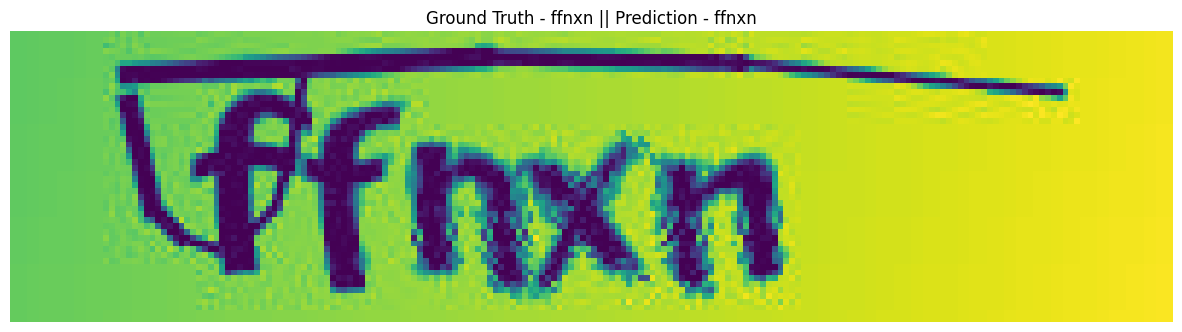

In [92]:
image_path = "./samples/ffnxn.png" #data[ids]


def show_prediction(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("L")
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    out, _, _ = model(image_tensor)
    gt = image_path.split('/')[-1].split('.')[0]

    out = out.permute(1, 0, 2)
    out = out.log_softmax(2)
    out = out.argmax(-1)
    decoded_out = decode_ctc(out, class_to_symbol)

    plt.figure(figsize=(15, 12))
    img_array = np.asarray(image)
    plt.title(f'Ground Truth - {gt} || Prediction - {decoded_out[0]}')
    plt.axis('off')
    plt.imshow(img_array)
    
show_prediction(model, image_path)

for 

In [ ]:
decoded_outs, decoded_labs_all

In [94]:
decoded_outs = [captcha for sublist in decoded_outs for captcha in sublist]

In [96]:
decoded_labs_all = [captcha for sublist in decoded_labs_all for captcha in sublist]

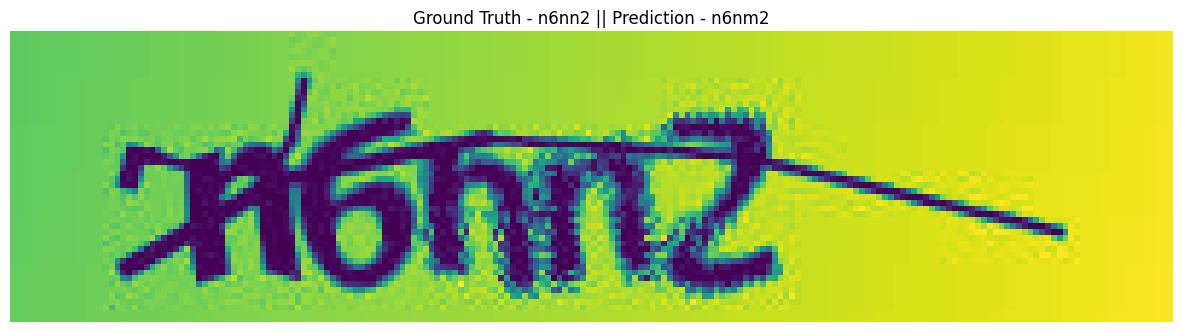

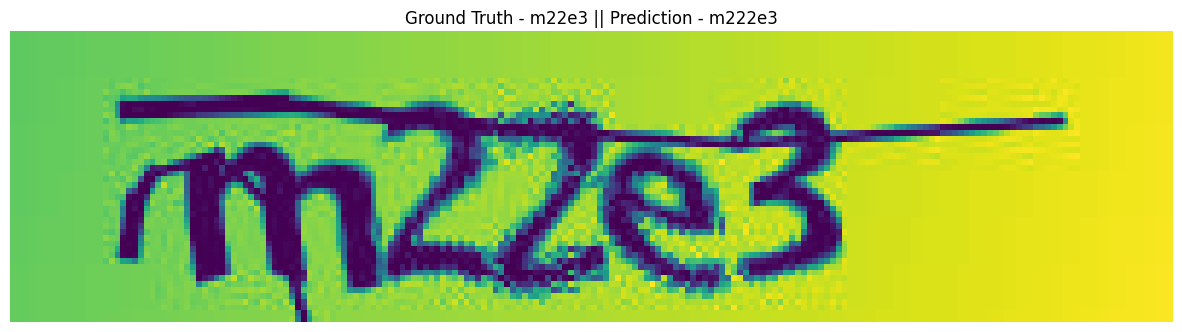

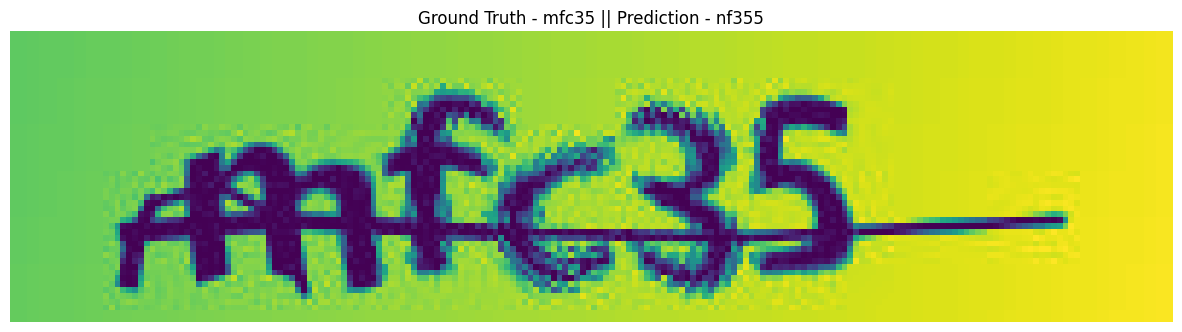

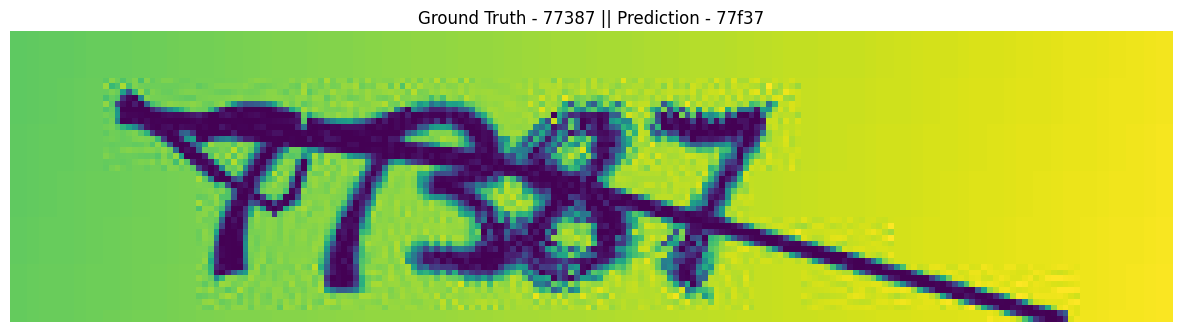

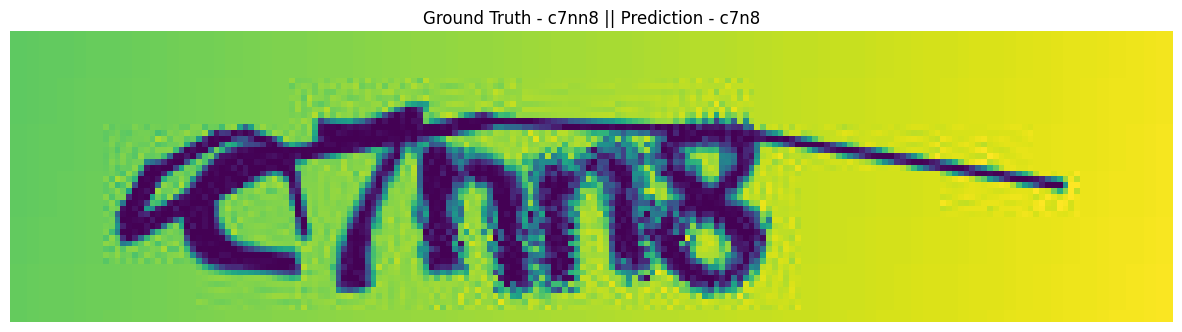

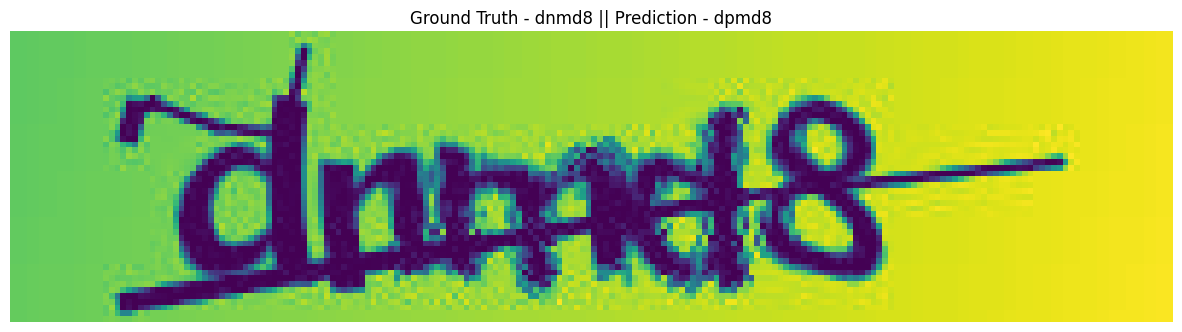

In [99]:
wrong_counter = 0
for idx, (pred, gt) in enumerate(zip(decoded_outs, decoded_labs_all)):
    if pred != gt:
        image_path = "./samples/" + f"{gt}.png"
        show_prediction(model, image_path)
        wrong_counter += 1
    if wrong_counter > 5:
        break

- Картинка 1. Возможно модель увидела m
- Картинка 2. Странное декодирование предсказаний модели, что получилось 6 букв
- Картинка 5. `n` немного похоже на `p` 

# References
- https://arxiv.org/pdf/1507.05717.pdf
- https://www.kaggle.com/code/kowalskyyy999/captcha-recognition-crnn-ctcloss-using-pytorch
- https://www.kaggle.com/code/lestervioleta/captcha-recognition-model
- https://actamachina.com/notebooks/2019/03/28/captcha.html